In [1]:
import os, sys, pathlib
mymodules = os.fspath(pathlib.Path.cwd().joinpath('CustomModules'))
if mymodules not in sys.path:
    sys.path.append(mymodules)
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd

plt.style.use('seaborn-white')
%matplotlib inline

import calciumGroupFunctions as g
import helperfunctionsfMRI as fh
import importlib, plottools
importlib.reload(plottools)
g = importlib.reload(g)

## Settings
Load all .mat files in any subfolder of *file_path*.
Later, load all BOLD ROI .1D files in same folder.

In [9]:
file_path = r'D:\MRIDATA\Calciumanalysis\GRCaMP\3Hz\groupstats'

calciumfiles = g.get_filepaths(file_path)

# Part 1: Calcium files

datatype
mean    1.041494
mean    0.782736
mean    0.520877
mean    0.333514
Name: std, dtype: float64


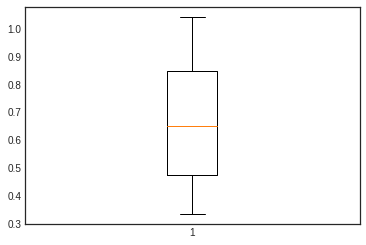

datatype
mean    0.753417
mean    1.491908
mean    0.513527
mean    0.295822
Name: std, dtype: float64


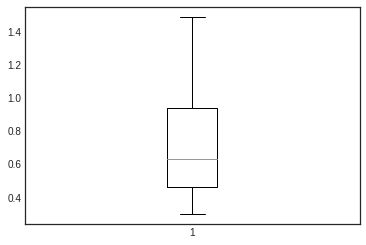

In [3]:
stim_events, calcium_df, measurements = g.extract_mat_data(*g.append_all_data(calciumfiles))

forplotting_individual=[]
forplotting_individual.append(calcium_df['channel1']['mean'])
forplotting_individual.append(calcium_df['channel2']['mean'])

# experimental: consider baseline before each stimulus block. scale all scans to have the same SD (~SNR)
normalized={}
normalized['ch1'] = g.normalize_by_bsl(forplotting_individual[0], bsl_duration=10, targetSD=1)
normalized['ch2'] = g.normalize_by_bsl(forplotting_individual[1], bsl_duration=10, targetSD=1)
normalized['ch1'].columns = normalized['ch2'].columns = measurements
# the box plots show the distribution of the individual baseline standard devidation values.

## Plot calcium responses of each scan and mean

In [15]:
plottools.plotlyplot(normalized['ch1'], stim_events, duration=0.1, titleinput='neurons')
plottools.plotlyplot(normalized['ch2'], stim_events, duration=0.1, titleinput='astrocytes')

## Gamma variate fit
**motivation**: Each calcium *spike* should approximately look like a gamma variate. If the system behaves linearly, a stimulation block could then be fitted by a sum of gamma variates of identical shape (informed by all spikes) but different amplitude (fitted to each spike separately, account for adaptation).

**option**: If the indicator dynamics or cell type cannot resolve responses to individual pulses, the overall shape may be approximated by a single gammavariate (for this, use the option singlegamma=True)

In [4]:
fitresults = {}
results_small = {}
fitresults['ch1'], results_small['ch1'] = g.RunFit_multi(normalized['ch1'], stim_events)
fitresults['ch2'], results_small['ch2'] = g.RunFit_multi(normalized['ch2'], stim_events, singlegamma=False)

fitting 6757_E6 (2)
fitting 6756_E6
fitting 6759_E5
fitting 6758_E7 (2)
-----
fitting 6757_E6 (2)
fitting 6756_E6
fitting 6759_E5
fitting 6758_E7 (2)
-----


## Plot individual block averages and fits

In [17]:
g.interactive_plot(fitresults)

interactive(children=(Dropdown(description='channel', options=('ch1', 'ch2'), value='ch1'), Dropdown(descripti…

#use code below to investigate weird fits (probably boundaries need to be changed then)

x=fitresults['ch2']
print(x.keys())
y=x['6758_E7 (2)']
print(y.fit_report())

## Store calcium traces, mean, and descriptive parameters in Excel sheet

In [17]:
parameters={}
parameters['ch1'] = g.get_descriptive_values(fitresults['ch1'])
parameters['ch2'] = g.get_descriptive_values(fitresults['ch2'])

normalized['ch1'] = g.add_mean_SD(normalized['ch1'])
normalized['ch2'] = g.add_mean_SD(normalized['ch2'])


forexcel={} # below, add the sheet-names and corresponding dataframes in the order of your choice.
forexcel['RCaMP_traces'] = normalized['ch1']
forexcel['RCaMP_stats'] = parameters['ch1']
forexcel['GCaMP_traces'] = normalized['ch2']
forexcel['GCaMP_stats'] = parameters['ch2']

g.excel_multi_sheets(forexcel,file_path)

dict_keys(['ID', 'ttp_single', 'alpha', 'ttp_overall', 'mean_amplitude', 'max_amplitude'])
dict_keys(['ID', 'ttp_single', 'alpha', 'ttp_overall', 'mean_amplitude', 'max_amplitude'])
mean/SD already added
mean/SD already added
stored data under /home/felix/Desktop/examplescan/calciumgroupstats/Results.xlsx


# Part 2: BOLD traces

In [12]:
BOLD_ROIs = g.load_afni_rois(file_path, file_ending='*ROIdataNEW.1D') # file-ending may have to be adjusted.

loading: ['D:\\MRIDATA\\Calciumanalysis\\GRCaMP\\3Hz\\groupstats\\6756_E7ROIdataNew.1D', 'D:\\MRIDATA\\Calciumanalysis\\GRCaMP\\3Hz\\groupstats\\6757_E8ROIdataNew.1D', 'D:\\MRIDATA\\Calciumanalysis\\GRCaMP\\3Hz\\groupstats\\6758_E9ROIdataNew.1D', 'D:\\MRIDATA\\Calciumanalysis\\GRCaMP\\3Hz\\groupstats\\6759_E6ROIdataNew.1D', 'D:\\MRIDATA\\Calciumanalysis\\GRCaMP\\3Hz\\groupstats\\6760_E9ROIdataNew.1D', 'D:\\MRIDATA\\Calciumanalysis\\GRCaMP\\3Hz\\groupstats\\6761_E7ROIdataNew.1D']


Define full length stimulus paradigm (for red line plots)

In [13]:
# --- Define the stimulation paradigm (all units in seconds):
paradigm['baseline'] = 120
paradigm['stim_duration'] = 8 
paradigm['Nblocks'] = 10
paradigm['ISI'] = 90  # Inter-stimulus interval (on+off period)
paradigm['frequency'] = 4 

paradigm['initial_cutoff'] = 30 # number of volumes to remove (in absence of dummy scans).


paradigm['stim_times'], paradigm['stim_onsets'], paradigm['stim_times_all'], paradigm['singleblock'] = fh.CreateStimParadigm(paradigm)

[110, 200, 290, 380, 470, 560, 650, 740, 830, 920]


### Plot full scan durations

In [15]:
plot = BOLD_ROIs.filter(regex='LHP')
plottools.plotlyplot(plot, paradigm['stim_onsets'], duration=paradigm['stim_duration'])
plot = BOLD_ROIs.filter(regex='RHP')
plottools.plotlyplot(plot, paradigm['stim_onsets'], duration=paradigm['stim_duration'])

In [ ]:
fh.averageblocks(inputdf, paradigm, averaging)